# Chatbot con voz

Iniciamos importando las librerías requeridas para este proyecto

In [1]:
import speech_recognition as sr

import json

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import cess_esp
from nltk.tag.hmm import HiddenMarkovModelTagger

from nltk.chunk.regexp import *

from urllib.request import Request, urlopen

import requests, pyttsx3

from deep_translator import GoogleTranslator


In [2]:
hmm = HiddenMarkovModelTagger.train(cess_esp.tagged_sents())

In [3]:
def tokenizar(_frase):
    return word_tokenize(_frase)

def taggear(_tokens):
    return hmm.tag(_tokens)

In [4]:
taggear(tokenizar('Quiero saber el resultado del Barcelona contra Betis'))

[('Quiero', 'sps00'),
 ('saber', 'vmn0000'),
 ('el', 'da0ms0'),
 ('resultado', 'ncms000'),
 ('del', 'spcms'),
 ('Barcelona', 'np0000l'),
 ('contra', 'sps00'),
 ('Betis', 'np0000o')]

In [5]:
reglas = """
Equipo: { <np.*> }
Equipo: { <da.* | np.* > <np.*> }
Partido: { <Equipo>  <sp.*> <Equipo> }
"""
parser = nltk.RegexpParser(reglas)


In [6]:
corpus_fix = [
    [('Manchester United', 'NP00000'), ('Real Madrid', 'NP00000')]
]

hmm.train(corpus_fix)

<HiddenMarkovModelTagger 1 states and 2 output symbols>

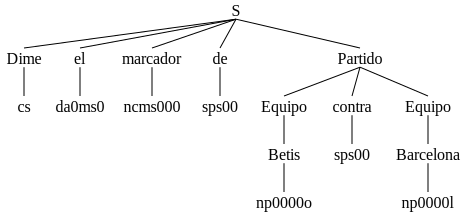

In [7]:
parser.parse(taggear(tokenizar('Dime el marcador de Betis contra Barcelona')))

In [8]:
def obtener_Info(_tree):
    result = []

    for nodo in _tree:
        if(type(nodo) != tuple):
            #Si encuentra un nodo de tipo partido
            if(nodo.label() == 'Partido'):
                partido = ''
                for elemento in nodo:
                    if(type(elemento) != tuple):
                        if(elemento.label() == 'Equipo'):
                            partido += ' '.join([ hoja[0] for hoja in elemento.leaves()]) + ' '
    #Vamos a formar el parámetro que se va a enviar a la API
    #Sevilla_vs_Valencia
    return partido.strip().replace(' ', '_vs_')


In [9]:
frase = parser.parse(taggear(tokenizar('Dime el marcador de Sevilla contra Valencia')))

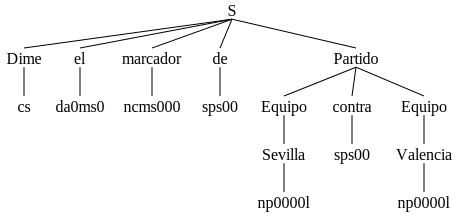

In [10]:
frase

In [11]:
def obtener_Marcador(_frase):
    url = 'https://www.thesportsdb.com/api/v1/json/3/searchevents.php?e=' + obtener_Info(frase)    
    data = requests.get(url)
    evento = json.loads(data.text)
    if(evento['event'][0]['intHomeScore'] == None):
        return 'Este encuentro no se ha disputado'
    return f"El resultado del último encuentro de {evento['event'][0]['strHomeTeam']} y {evento['event'][0]['strAwayTeam']} fue de {evento['event'][0]['intHomeScore']} a {evento['event'][0]['intAwayScore']}"

In [12]:
def listen():
    mic = sr.Microphone()
    with mic as source:
        instance = sr.Recognizer()
        audio = instance.listen(source)
        transcript = instance.recognize_google(audio, language='es-ES', show_all=True)
        print(transcript['alternative'][0]['transcript'])
        return transcript['alternative'][0]['transcript']

In [13]:
engine = pyttsx3.init()
def speak(_text, _voice = 0):
    voices = engine.getProperty('voices')
    engine.setProperty('voice', voices[_voice].id)
    engine.setProperty('rate', 130)
    engine.say(_text)
    engine.runAndWait()

In [14]:
voices = engine.getProperty('voices')

for voice in voices:
    print(voice.name)

Microsoft David Desktop - English (United States)
Microsoft Zira Desktop - English (United States)
Microsoft Helena Desktop - Spanish (Spain)
Microsoft Sabina Desktop - Spanish (Mexico)
Microsoft Maria Desktop - Portuguese(Brazil)


In [19]:
frase = parser.parse(taggear(tokenizar(listen())))
resultado = obtener_Marcador(obtener_Info(frase))
print(resultado)
speak(resultado, 3)

en el marcador de Getafe contra Barcelona
El resultado del último encuentro de Getafe y Barcelona fue de 0 a 0


Para poder hacer tagging de jugadores y de equipos, que tienen reglas gramaticales similares, podría implementarse un segundo parser que detecte jugadores con base en la detección de palabras claves que dejen entrever que se está preguntando por un jugador y no por un partido